## Import Modules

In [75]:
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from datetime import datetime
from scipy.optimize import minimize

In [76]:
from typing import Iterable 
#from collections imtmp Iterable                            

def flatten(items):
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

## Import Data

In [77]:
df_price = pd.read_excel("Price.xlsx", index_col=0) 
df_price.index = df_price.index.to_series().dt.to_period('M')
df_price

,Mnemonic,Close
Date,,
2019-12,4SI:XJSE:EQU,32.0
2019-11,4SI:XJSE:EQU,20.0
2019-10,4SI:XJSE:EQU,20.0
2019-09,4SI:XJSE:EQU,20.0
2019-08,4SI:XJSE:EQU,18.0
...,...,...
2009-05,ZED:XJSE:EQU,144.0
2009-04,ZED:XJSE:EQU,148.0
2009-03,ZED:XJSE:EQU,140.0


In [78]:
df_size = pd.read_excel("Market Capitalizations.xlsx", usecols=[0,2,3], index_col=1)
df_size.index = df_size.index.to_series().dt.to_period('M')
df_size

,Mnemonic,Market Cap
Date,,
2019-12,4SI:XJSE:EQU,253217582.0
2019-11,4SI:XJSE:EQU,158260989.0
2019-10,4SI:XJSE:EQU,158260989.0
2019-09,4SI:XJSE:EQU,158260989.0
2019-08,4SI:XJSE:EQU,142434890.0
...,...,...
2009-05,ZED:XJSE:EQU,880279665.0
2009-04,ZED:XJSE:EQU,904687478.0
2009-03,ZED:XJSE:EQU,855785452.0


In [79]:
df_MR = pd.read_excel("J203T Price.xlsx", usecols=[0,1], index_col=0)
df_MR

,J203T
Dates,
2000-01-04,694.664
2000-01-05,687.378
2000-01-06,688.400
2000-01-07,705.859
2000-01-10,729.218
...,...
2020-02-24,8332.211
2020-02-25,8321.271
2020-02-26,8357.358


In [80]:
df_RF = pd.read_excel("91days T-Bill rate.xlsx", index_col=0)
df_RF


,Value
Date,
2000-01-05,10.71
2000-01-06,10.71
2000-01-07,10.56
2000-01-10,10.56
2000-01-11,10.56
...,...
2019-12-25,7.19
2019-12-26,7.19
2019-12-27,7.16


## Sorting Data

Reform price data frame

In [81]:
tmp = pd.DataFrame()
labels = []
n = int((2019-2009+1)*12)

for i in range(int(len(df_price)/n)): 
    price = pd.DataFrame(df_price.iloc[n*i:n*(i+1),1])
    name = df_price.iloc[range(1,len(df_price),n)[i],0]
    tmp = pd.concat([tmp,price], axis=1)
    labels.append(name)
    tmp.columns = [labels]


In [82]:
df_price = tmp
df_price = df_price.sort_index(ascending=True)
df_price.columns = df_price.columns.get_level_values(0).values
df_price

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,9300.0,NaN,NaN,4000.0,2290.0,NaN,370.0,5099.0,NaN,...,905.0,1750.0,116.0,64.0,9718.0,1345.0,32.0,NaN,1600.0,155.0
2009-02,NaN,8900.0,NaN,NaN,3826.0,2050.0,NaN,350.0,4399.0,NaN,...,825.0,850.0,108.0,40.0,8500.0,1190.0,25.0,NaN,1150.0,146.0
2009-03,NaN,9620.0,NaN,NaN,3600.0,1700.0,NaN,371.0,4400.0,NaN,...,919.0,1500.0,120.0,54.0,8509.0,1140.0,18.0,NaN,540.0,140.0
2009-04,NaN,9845.0,NaN,NaN,4200.0,2100.0,NaN,400.0,4875.0,NaN,...,930.0,750.0,134.0,70.0,10001.0,1200.0,18.0,NaN,540.0,148.0
2009-05,NaN,10155.0,NaN,NaN,4200.0,2300.0,NaN,415.0,4600.0,NaN,...,960.0,600.0,170.0,55.0,10355.0,1250.0,22.0,NaN,460.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,18.0,15369.0,295.0,725.0,5775.0,2000.0,45.0,1109.0,9099.0,NaN,...,1872.0,255.0,40.0,3.0,10018.0,5518.0,140.0,1800.0,170.0,470.0
2019-09,20.0,15287.0,174.0,725.0,5675.0,2055.0,38.0,1250.0,9596.0,NaN,...,1900.0,255.0,52.0,3.0,14290.0,5508.0,160.0,1840.0,160.0,470.0
2019-10,20.0,15488.0,198.0,600.0,5624.0,1370.0,42.0,1125.0,9765.0,NaN,...,1934.0,250.0,55.0,3.0,14118.0,5749.0,160.0,1865.0,160.0,490.0


Reform size data frame

In [83]:
tmp = pd.DataFrame()

for i in range(int(len(df_size)/n)): 
    size = pd.DataFrame(df_size.iloc[n*i:n*(i+1),1])
    tmp = pd.concat([tmp,size], axis=1)
tmp.columns = flatten([labels])

In [84]:
df_size = tmp
# reorder the date of size data
df_size = df_size.sort_index(ascending=True)
df_size

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,6.326588e+10,NaN,NaN,6.916287e+09,1.238633e+09,NaN,1.456560e+09,6.060008e+09,NaN,...,2.674735e+09,431987500.0,679168221.0,117095434.0,6.413880e+09,1.074192e+10,76800000.0,NaN,1.253921e+09,9.474768e+08
2009-02,NaN,6.054477e+10,NaN,NaN,6.615428e+09,1.111497e+09,NaN,1.377827e+09,5.228079e+09,NaN,...,2.438295e+09,209822500.0,632329033.0,73184646.0,5.610000e+09,9.504005e+09,60000000.0,NaN,9.012558e+08,8.924620e+08
2009-03,NaN,6.545181e+10,NaN,NaN,6.224658e+09,9.217295e+08,NaN,1.460497e+09,5.229267e+09,NaN,...,2.716113e+09,370275000.0,702587815.0,98799273.0,5.615940e+09,9.112693e+09,43200000.0,NaN,4.231984e+08,8.557855e+08
2009-04,NaN,6.698264e+10,NaN,NaN,7.262101e+09,1.138607e+09,NaN,1.574660e+09,5.793791e+09,NaN,...,2.748623e+09,185137500.0,784556393.0,128073131.0,6.600660e+09,9.592308e+09,43200000.0,NaN,4.231984e+08,9.046875e+08
2009-05,NaN,6.909180e+10,NaN,NaN,7.262101e+09,1.247046e+09,NaN,1.633709e+09,5.466961e+09,NaN,...,2.837288e+09,148110000.0,995332738.0,100903889.0,6.834300e+09,9.991988e+09,52800000.0,NaN,3.605023e+08,8.802797e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,142434890.0,1.302908e+11,2.945648e+09,2.863460e+09,1.015007e+10,2.199094e+09,129594794.0,6.061937e+09,1.108523e+10,NaN,...,1.790056e+10,410947583.0,651130823.0,8291796.0,5.999832e+09,5.785436e+10,341223880.0,9.524873e+08,5.631090e+08,8.061342e+09
2019-09,158260989.0,1.295956e+11,1.737433e+09,2.863460e+09,9.974315e+09,2.259569e+09,109435604.0,6.832661e+09,1.169072e+10,NaN,...,1.816831e+10,410947583.0,846470070.0,8291796.0,8.558354e+09,5.774957e+10,389970148.0,9.736537e+08,5.299850e+08,8.061342e+09
2019-10,158260989.0,1.312996e+11,1.977079e+09,2.369760e+09,9.884678e+09,1.506379e+09,120955141.0,6.149395e+09,1.189661e+10,NaN,...,1.849342e+10,402889787.0,895304881.0,8291796.0,8.455343e+09,6.027737e+10,389970148.0,9.868827e+08,5.299850e+08,8.404378e+09


Calculate stock returns

In [85]:

df_SR = np.log(df_price/df_price.shift(1))
df_SR = df_SR.iloc[1:,:]
df_SR.replace([np.inf, -np.inf], np.nan, inplace=True)  
df_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,-0.043963,NaN,NaN,-0.044474,-0.110712,NaN,-0.055570,-0.147667,NaN,...,-0.092552,-0.722135,-0.071459,-0.470004,-0.133914,-0.122441,-0.246860,NaN,-0.330242,-0.059818
2009-03,NaN,0.077793,NaN,NaN,-0.060886,-0.187212,NaN,0.058269,0.000227,NaN,...,0.107903,0.567984,0.105361,0.300105,0.001058,-0.042925,-0.328504,NaN,-0.755948,-0.041964
2009-04,NaN,0.023119,NaN,NaN,0.154151,0.211309,NaN,0.075262,0.102516,NaN,...,0.011898,-0.693147,0.110348,0.259511,0.161561,0.051293,0.000000,NaN,0.000000,0.055570
2009-05,NaN,0.031002,NaN,NaN,0.000000,0.090972,NaN,0.036814,-0.058064,NaN,...,0.031749,-0.223144,0.237959,-0.241162,0.034784,0.040822,0.200671,NaN,-0.160343,-0.027399
2009-06,NaN,0.079929,NaN,NaN,0.015123,0.042560,NaN,0.035507,0.010811,NaN,...,-0.121697,-0.182322,0.344840,-0.178692,0.025270,0.035367,0.127833,NaN,-0.044452,0.006920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,0.000000,-0.038234,0.000000,0.189242,0.006079,-0.159138,-0.200671,-0.131613,-0.021850,NaN,...,-0.008511,0.060625,0.025318,0.000000,-0.140656,0.003267,-0.035091,0.045462,0.000000,-0.031416
2019-09,0.105361,-0.005350,-0.527920,0.000000,-0.017468,0.027129,-0.169076,0.119685,0.053182,NaN,...,0.014847,0.000000,0.262364,0.000000,0.355177,-0.001814,0.133531,0.021979,-0.060625,0.000000
2019-10,0.000000,0.013063,0.129212,-0.189242,-0.009027,-0.405465,0.100083,-0.105361,0.017458,NaN,...,0.017737,-0.019803,0.056089,0.000000,-0.012109,0.042824,0.000000,0.013495,0.000000,0.041673


Calculate risk-free and market returns

In [86]:
df_RF = (1+df_RF['Value'].astype(np.float64)/100)**(1/365)-1
df_RF.index = pd.to_datetime(df_RF.index)
df_RF = pd.DataFrame(df_RF.resample('M').sum())
df_RF.index = df_RF.index.to_series().dt.to_period('M')
df_RF = df_RF.loc[df_SR.index,:]
df_RF

,Value
Date,
2009-02,0.004854
2009-03,0.004984
2009-04,0.004798
2009-05,0.004276
2009-06,0.004203
...,...
2019-08,0.004076
2019-09,0.003813
2019-10,0.004153


In [87]:
tmp = np.log(df_MR/df_MR.shift(1))
df_MR = tmp.iloc[1:,:]
df_MR.index = pd.to_datetime(df_MR.index)
df_MR = pd.DataFrame(df_MR.resample('M',convention='end').sum())
df_MR.index = df_MR.index.to_series().dt.to_period('M')
df_MR = df_MR.loc[df_SR.index,:]
df_MR

,J203T
Date,
2009-02,-0.103955
2009-03,0.104531
2009-04,0.015669
2009-05,0.098319
2009-06,-0.031028
...,...
2019-08,-0.024655
2019-09,0.001913
2019-10,0.030952


In [88]:
df_size = df_size.loc[df_SR.index,:]

Calculate stock excess returns

In [89]:
df_Ex_SR = df_SR.apply(lambda x: x-df_RF.iloc[:,0], axis=0)
df_Ex_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,-0.048818,NaN,NaN,-0.049329,-0.115567,NaN,-0.060424,-0.152522,NaN,...,-0.097406,-0.726989,-0.076313,-0.474858,-0.138768,-0.127295,-0.251715,NaN,-0.335096,-0.064673
2009-03,NaN,0.072809,NaN,NaN,-0.065870,-0.192196,NaN,0.053285,-0.004757,NaN,...,0.102918,0.563000,0.100376,0.295120,-0.003926,-0.047909,-0.333488,NaN,-0.760932,-0.046949
2009-04,NaN,0.018321,NaN,NaN,0.149353,0.206511,NaN,0.070464,0.097717,NaN,...,0.007100,-0.697945,0.105550,0.254713,0.156763,0.046495,-0.004798,NaN,-0.004798,0.050772
2009-05,NaN,0.026726,NaN,NaN,-0.004276,0.086696,NaN,0.032538,-0.062340,NaN,...,0.027473,-0.227420,0.233683,-0.245438,0.030508,0.036546,0.196395,NaN,-0.164619,-0.031675
2009-06,NaN,0.075726,NaN,NaN,0.010920,0.038356,NaN,0.031303,0.006608,NaN,...,-0.125900,-0.186525,0.340637,-0.182895,0.021066,0.031164,0.123630,NaN,-0.048655,0.002717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,-0.004076,-0.042310,-0.004076,0.185166,0.002003,-0.163214,-0.204746,-0.135689,-0.025925,NaN,...,-0.012586,0.056549,0.021242,-0.004076,-0.144731,-0.000808,-0.039167,0.041387,-0.004076,-0.035492
2019-09,0.101547,-0.009163,-0.531733,-0.003813,-0.021281,0.023315,-0.172890,0.115872,0.049368,NaN,...,0.011033,-0.003813,0.258551,-0.003813,0.351363,-0.005627,0.129718,0.018166,-0.064438,-0.003813
2019-10,-0.004153,0.008910,0.125059,-0.193395,-0.013180,-0.409618,0.095931,-0.109513,0.013305,NaN,...,0.013584,-0.023955,0.051937,-0.004153,-0.016262,0.038672,-0.004153,0.009343,-0.004153,0.037520


## CAPM Regression (Time-Varying Betas)

In [90]:
holding = 3 # 3, 6, 12, 36, 72 (H); holding periods
rollingW = 12 # 3,6,12,36,72 (E); estimation periods
lens = len(df_Ex_SR)
periods = int((lens - rollingW) / holding) 
print(periods,rollingW)

39 12


In [91]:
all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR.iloc[i*holding:i*holding+rollingW,:]

    betas = []
    labels = []
    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        if len(df_index) >= 2: 
            ols = sm.OLS(df_Ex_SR_tmp.loc[df_index,j].values.astype(np.float64), 
            sm.add_constant(df_MR_tmp.loc[df_index,:].values.astype(np.float64)))
            res = ols.fit()
            b = res.params[1] 
            betas.append(b)
            labels.append(j)

    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'Beta'})
    df_betas.index = labels
    all_betas.append(df_betas)

100%|██████████| 39/39 [00:05<00:00,  6.93it/s]


## Ranking Betas

In [92]:
Ranks = []

for i in range(periods):
    rank_betas = all_betas[i].sort_values(by="Beta")
    number_of_portfolios = 5
    N = len(rank_betas)
    quantile = int(N/number_of_portfolios)
    ranks = {"Low_Beta":rank_betas.index[0:quantile],
            "P1":rank_betas.index[(quantile+1):(2*quantile)],
            "P2":rank_betas.index[(2*quantile+1):(3*quantile)],
            "P3":rank_betas.index[(3*quantile+1):(N-quantile)],
            "High_Beta":rank_betas.index[(N-quantile+1):N]}
    Ranks.append(ranks)


## Portfolio Optimization

In [93]:
lookback_return_list = []
holding_return_list = []

for i in tqdm(range(periods)):
  lookback_return_list.append(df_SR.iloc[i*holding:i*holding+rollingW,:])
  holding_return_list.append(df_SR.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])

100%|██████████| 39/39 [00:00<00:00, 12572.27it/s]


In [94]:
lookback_size_list = []
holding_size_list = []

for i in tqdm(range(periods)):
  lookback_size_list.append(df_size.iloc[i*holding:i*holding+rollingW,:])
  holding_size_list.append(df_size.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])

100%|██████████| 39/39 [00:00<00:00, 8290.82it/s]


### 1. The naive equally-weighted portfolio of all stocks (EW)

In [95]:
def hld_period_calcs(a):
    port = a
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [96]:
EW = list(map(hld_period_calcs, holding_return_list))

In [97]:
df_portfolio = pd.DataFrame()
df_portfolio["MR_RF"] = np.round((df_MR-df_RF.values)[rollingW:][0:periods*holding],4)
df_portfolio["EW"] = np.concatenate(EW)

In [98]:
df_portfolio

,MR_RF,EW
Date,,
2010-02,-0.0000,0.0131
2010-03,0.0715,0.0280
2010-04,-0.0044,0.0118
2010-05,-0.0561,-0.0224
2010-06,-0.0360,-0.0276
...,...,...
2019-06,0.0429,-0.0296
2019-07,-0.0283,-0.0256
2019-08,-0.0287,-0.0462


### 2. Equal-Weighted lowbeta portfolio (EW)

In [99]:
def hld_period_calcs1(a,b):
    index = a.columns.intersection(b["Low_Beta"])
    port = a[index]
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [100]:
Lowbeta = list(map(hld_period_calcs1, holding_return_list, Ranks))

In [101]:
df_portfolio["Lowbeta"] = np.concatenate(Lowbeta)
df_portfolio

,MR_RF,EW,Lowbeta
Date,,,
2010-02,-0.0000,0.0131,-0.0008
2010-03,0.0715,0.0280,0.0361
2010-04,-0.0044,0.0118,0.0160
2010-05,-0.0561,-0.0224,-0.0127
2010-06,-0.0360,-0.0276,-0.0009
...,...,...,...
2019-06,0.0429,-0.0296,-0.0605
2019-07,-0.0283,-0.0256,-0.0260
2019-08,-0.0287,-0.0462,-0.0267


### 3. Market Capitalization-Weighted (MCW) 

In [102]:
mcap_wght = []

for i in range(periods):
    tmp = holding_size_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:,(tmp != 0).any(axis=0)].astype(np.float64)
    tmp = tmp.loc[:,(np.isnan(tmp)==False).any(axis=0)].astype(np.float64)
    wght = pd.DataFrame()
    wght = tmp/np.nansum(tmp)
    mcap_wght.append(wght)


In [103]:
def hld_period_calcs2(a,b,weights):
    port = a[weights.columns]
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64) 
    port = port.loc[:, (~np.isnan(port).all(axis=0))].astype(np.float64) 
    index = port.columns.intersection(weights.columns)
    port = port[index]
    weights = weights[index]
    level = pd.concat([pd.DataFrame(weights.iloc[0,:]).T, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round((value[1:len(value)].values-value[0:len(value)-1].values)/value[0:len(value)-1].values,4)
    return returns

In [104]:
MCW = list(map(hld_period_calcs2,holding_return_list, Ranks, mcap_wght))

In [105]:
df_portfolio["MCW"] = np.concatenate(MCW)
df_portfolio

,MR_RF,EW,Lowbeta,MCW
Date,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094
2010-03,0.0715,0.0280,0.0361,0.0322
2010-04,-0.0044,0.0118,0.0160,0.0275
2010-05,-0.0561,-0.0224,-0.0127,-0.0628
2010-06,-0.0360,-0.0276,-0.0009,-0.0386
...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065
2019-07,-0.0283,-0.0256,-0.0260,0.0045
2019-08,-0.0287,-0.0462,-0.0267,0.0042


### 4. Minimum Variance Portfolio (MVP)

With long-only constrains

In [106]:
from scipy.optimize import minimize

In [107]:
def objective(wght): 
    wght = np.array(wght)
    return wght.dot(tmp.cov()).dot(wght.T)

MVPL_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) 
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) 
    
    cons  = ({"type":"eq", "fun": lambda x: np.sum(x)-1}) 
    bounds = tuple((0,1) for x in range(tmp.shape[1])) 
    guess = [1./tmp.shape[1] for x in range(tmp.shape[1])]

    wght = []
    wght = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["MVPL_wght"], index=tmp.columns)

    MVPL_wght.append(wght.T)

In [108]:
MVPL = list(map(hld_period_calcs2,holding_return_list, Ranks, MVPL_wght))

In [109]:
df_portfolio["MVPL"] = np.concatenate(MVPL)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVPL
Date,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.0274
2010-03,0.0715,0.0280,0.0361,0.0322,0.0804
2010-04,-0.0044,0.0118,0.0160,0.0275,0.0261
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,-0.0626
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.0043
...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0105
2019-07,-0.0283,-0.0256,-0.0260,0.0045,-0.0044
2019-08,-0.0287,-0.0462,-0.0267,0.0042,-0.0468


In [110]:
(df_portfolio+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVPL
Date,,,,,
2010-02,1.000000,1.013100,0.999200,0.990600,1.027400
2010-03,1.071500,1.041467,1.035271,1.022497,1.110003
2010-04,1.066785,1.053756,1.051835,1.050616,1.138974
2010-05,1.006939,1.030152,1.038477,0.984637,1.067674
2010-06,0.970689,1.001720,1.037543,0.946630,1.072265
...,...,...,...,...,...
2019-06,1.798454,0.788581,0.462066,0.445996,1.347376
2019-07,1.747558,0.768393,0.450052,0.448003,1.341447
2019-08,1.697403,0.732894,0.438036,0.449885,1.278668


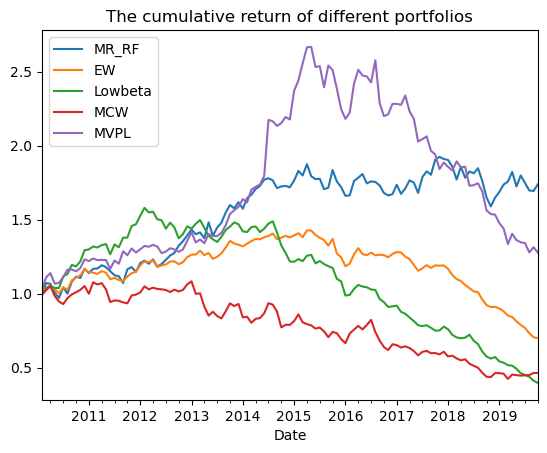

In [111]:
(df_portfolio+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

### 5. Equal Risk Contribution (ERC)

In [112]:
def calculate_portfolio_var(w,V):
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    MRC = V*w.T
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    V = pars[0]
    x_t = pars[1] 
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) 
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0]
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

ERC_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) 
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) 
    
    cons  = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})
    bounds = tuple((0,1) for x in range(tmp.shape[1])) 
    guess = [1./tmp.shape[1] for x in range(tmp.shape[1])] 
    x_t = [1./tmp.shape[1] for x in range(tmp.shape[1])] 
    
    V = np.asmatrix(tmp.cov()) 

    wght = []
    wght = minimize(risk_budget_objective, guess, args=[V,x_t], method='SLSQP',constraints=cons, bounds = bounds, options={'disp': False})
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["ERC_wght"], index=tmp.columns)

    ERC_wght.append(wght.T)

In [113]:
ERC = list(map(hld_period_calcs2,holding_return_list, Ranks, ERC_wght))

In [114]:
df_portfolio["ERC"] = np.concatenate(ERC)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVPL,ERC
Date,,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.0274,0.0035
2010-03,0.0715,0.0280,0.0361,0.0322,0.0804,0.0504
2010-04,-0.0044,0.0118,0.0160,0.0275,0.0261,0.0076
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,-0.0626,-0.0131
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.0043,-0.0034
...,...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0105,-0.0590
2019-07,-0.0283,-0.0256,-0.0260,0.0045,-0.0044,-0.0269
2019-08,-0.0287,-0.0462,-0.0267,0.0042,-0.0468,-0.0078


In [115]:
(df_portfolio+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVPL,ERC
Date,,,,,,
2010-02,1.000000,1.013100,0.999200,0.990600,1.027400,1.003500
2010-03,1.071500,1.041467,1.035271,1.022497,1.110003,1.054076
2010-04,1.066785,1.053756,1.051835,1.050616,1.138974,1.062087
2010-05,1.006939,1.030152,1.038477,0.984637,1.067674,1.048174
2010-06,0.970689,1.001720,1.037543,0.946630,1.072265,1.044610
...,...,...,...,...,...,...
2019-06,1.798454,0.788581,0.462066,0.445996,1.347376,0.654741
2019-07,1.747558,0.768393,0.450052,0.448003,1.341447,0.637129
2019-08,1.697403,0.732894,0.438036,0.449885,1.278668,0.632159


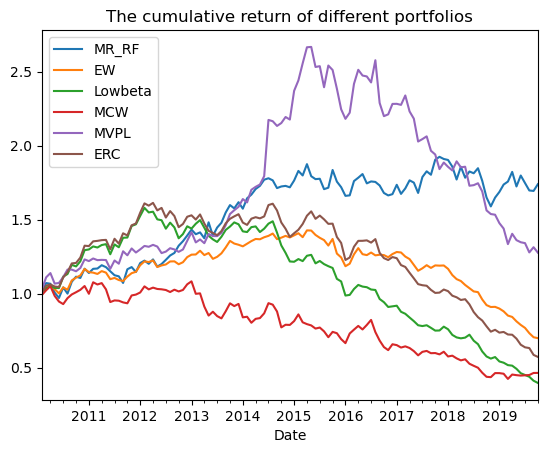

In [116]:
(df_portfolio+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

### 6. Naive Risk Parity (NRP)

In [117]:
NRP_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) 
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) 
    
    wght = pd.DataFrame((1/tmp.std())/np.sum((1/tmp.std())), columns=["NRP_wght"], index=tmp.columns)
    NRP_wght.append(wght.T)

In [118]:
NRP = list(map(hld_period_calcs2,holding_return_list, Ranks, NRP_wght))

In [119]:
df_portfolio["NRP"] = np.concatenate(NRP)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVPL,ERC,NRP
Date,,,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.0274,0.0035,0.0067
2010-03,0.0715,0.0280,0.0361,0.0322,0.0804,0.0504,0.0484
2010-04,-0.0044,0.0118,0.0160,0.0275,0.0261,0.0076,0.0216
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,-0.0626,-0.0131,-0.0158
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.0043,-0.0034,-0.0083
...,...,...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0105,-0.0590,-0.0464
2019-07,-0.0283,-0.0256,-0.0260,0.0045,-0.0044,-0.0269,-0.0162
2019-08,-0.0287,-0.0462,-0.0267,0.0042,-0.0468,-0.0078,-0.0365


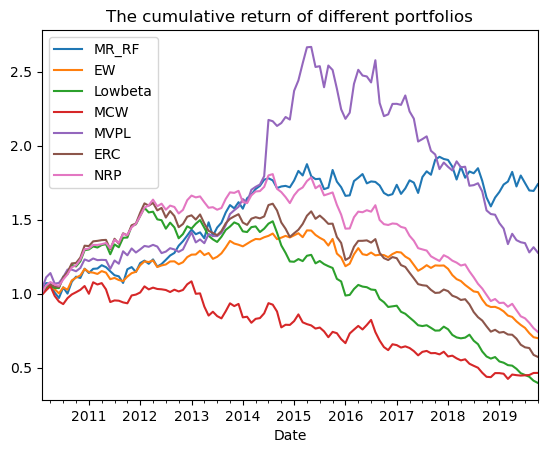

In [120]:
(df_portfolio+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

### 7. Maximum Diversification Portfolio (MDP)

In [121]:
def calc_diversification_ratio(w, V):
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    port_vol = np.sqrt(calculate_portfolio_var(w, V))
    diversification_ratio = w_vol/port_vol
    return -diversification_ratio 

def max_div_port(w0, V, bounds, long_only=True):
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only: 
        cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
    res = minimize(calc_diversification_ratio, w0, bounds=bounds, args=V, method='SLSQP', constraints=cons)
    return res

MDP_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) 
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64)

    bounds = tuple((0,1) for x in range(tmp.shape[1])) 
    w0 = [1./tmp.shape[1] for x in range(tmp.shape[1])] 
    V = np.asmatrix(tmp.cov())

    wght = []
    wght = max_div_port(w0, V, bounds=bounds, long_only=True)
    wght = wght.x
    wght = pd.DataFrame(wght, columns=["MDP_wght"], index=tmp.columns)

    MDP_wght.append(wght.T)

In [122]:
MDP = list(map(hld_period_calcs2,holding_return_list, Ranks, MDP_wght))

In [123]:
df_portfolio["MDP"] = np.concatenate(MDP)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVPL,ERC,NRP,MDP
Date,,,,,,,,
2010-02,-0.0000,0.0131,-0.0008,-0.0094,0.0274,0.0035,0.0067,0.0447
2010-03,0.0715,0.0280,0.0361,0.0322,0.0804,0.0504,0.0484,0.0936
2010-04,-0.0044,0.0118,0.0160,0.0275,0.0261,0.0076,0.0216,0.0369
2010-05,-0.0561,-0.0224,-0.0127,-0.0628,-0.0626,-0.0131,-0.0158,-0.0647
2010-06,-0.0360,-0.0276,-0.0009,-0.0386,0.0043,-0.0034,-0.0083,0.0057
...,...,...,...,...,...,...,...,...
2019-06,0.0429,-0.0296,-0.0605,-0.0065,-0.0105,-0.0590,-0.0464,0.0143
2019-07,-0.0283,-0.0256,-0.0260,0.0045,-0.0044,-0.0269,-0.0162,-0.1205
2019-08,-0.0287,-0.0462,-0.0267,0.0042,-0.0468,-0.0078,-0.0365,0.1452


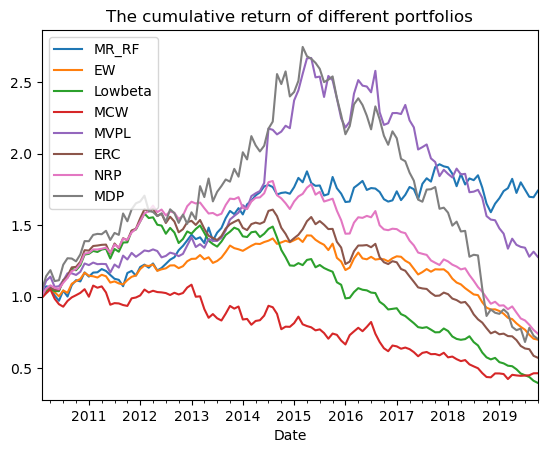

In [124]:
(df_portfolio+1).cumprod().plot(title = "The cumulative return of different portfolios")
plt.show()

Sharpe Ratio

In [125]:
pd.DataFrame(df_portfolio.apply(lambda x: x.mean()/x.std())).T

,MR_RF,EW,Lowbeta,MCW,MVPL,ERC,NRP,MDP
0,0.156674,-0.119526,-0.231533,-0.134967,0.070672,-0.135834,-0.078125,-0.023507


Treynor Ratio

In [126]:
import statsmodels.api as sm

In [127]:
betas = df_portfolio.drop('MR_RF', axis=1).apply(lambda x: sm.OLS(endog=x,
                                     exog=sm.add_constant(df_portfolio.loc[:,'MR_RF']))
                .fit(params_only=True)
                .params
                .drop('const'))
betas

,EW,Lowbeta,MCW,MVPL,ERC,NRP,MDP
MR_RF,0.466528,0.354036,0.432974,0.371415,0.326099,0.315075,0.393196


In [128]:
df_portfolio.drop('MR_RF',axis=1).mean()/betas

,EW,Lowbeta,MCW,MVPL,ERC,NRP,MDP
MR_RF,-0.005967,-0.020817,-0.013064,0.007866,-0.013081,-0.006893,-0.00343
